<a href="https://colab.research.google.com/github/mohammadarif2003/Sentiment_Analysis_and_Topic_Identification_in_MyTelkomsel_User_Feedback_mohammadarif2003/blob/main/Main_MyTelkomsel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
pip install google-play-scraper

In [2]:
pip install gensim

In [3]:
pip install Sastrawi

In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google_play_scraper import reviews, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from gensim.models import LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize

# Import Data

In [6]:
result, _ = reviews(
    'com.telkomsel.telkomselcm',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=5000,
    filter_score_with=None
)

df_selected = pd.DataFrame(result)[['content', 'score']]
print("10 Data Pertama:")
print(df_selected.head(10))

10 Data Pertama:
                                             content  score
0    Aplikasi yang selalu lemot kalo saat di buka!!!      1
1  malah gak bisa login.padahal dah di kasih ling...      2
2  masih sering downd, gabisa nampilin kuota dan ...      1
3                                                 ok      5
4  1.Jaringan sangat buruk walaupun saya pake kar...      1
5  ribet lah apk di satuin sama indihome.customer...      2
6  ada apa dengan My TELKOMSEL kenapa loading mul...      2
7  sudah sinyal lemot... buka aplikasi lemot.. se...      1
8  Layanannya sudah lebih lengkap dalam satu apli...      5
9                                                 ok      5


In [7]:
# Labeling Sentimen
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

df_selected['sentimen'] = df_selected['score'].apply(label_sentiment)
print("\n10 Data Pertama dengan Label Sentimen:")
print(df_selected.head(10))


10 Data Pertama dengan Label Sentimen:
                                             content  score sentimen
0    Aplikasi yang selalu lemot kalo saat di buka!!!      1  negatif
1  malah gak bisa login.padahal dah di kasih ling...      2  negatif
2  masih sering downd, gabisa nampilin kuota dan ...      1  negatif
3                                                 ok      5  positif
4  1.Jaringan sangat buruk walaupun saya pake kar...      1  negatif
5  ribet lah apk di satuin sama indihome.customer...      2  negatif
6  ada apa dengan My TELKOMSEL kenapa loading mul...      2  negatif
7  sudah sinyal lemot... buka aplikasi lemot.. se...      1  negatif
8  Layanannya sudah lebih lengkap dalam satu apli...      5  positif
9                                                 ok      5  positif


# Text Preprocessing

In [8]:
df_selected = df_selected[df_selected['content'].str.strip() != '']

normalization_dict = {
    'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak', 'ngk': 'tidak',
    'bgt': 'banget', 'dr': 'dari', 'tp': 'tapi', 'tdk': 'tidak', 'udh': 'sudah', 'sdh': 'sudah',
    'blm': 'belum', 'dgn': 'dengan', 'bgus': 'bagus', 'bgs': 'bagus', 'trs': 'terus', 'utk': 'untuk',
    'aja': 'saja', 'jg': 'juga', 'bikin': 'buat', 'sy': 'saya', 'lg': 'lagi', 'klo': 'kalau', 'klw': 'kalau', 'msh': 'masih'
}

def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

In [9]:
df_selected = df_selected[df_selected['content'].str.strip() != '']

normalization_dict = {
    'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak', 'ngk': 'tidak',
    'bgt': 'banget', 'dr': 'dari', 'tp': 'tapi', 'tdk': 'tidak', 'udh': 'sudah', 'sdh': 'sudah',
    'blm': 'belum', 'dgn': 'dengan', 'bgus': 'bagus', 'bgs': 'bagus', 'trs': 'terus', 'utk': 'untuk',
    'aja': 'saja', 'jg': 'juga', 'bikin': 'buat', 'sy': 'saya', 'lg': 'lagi', 'klo': 'kalau', 'klw': 'kalau', 'msh': 'masih'
}

def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)


extra_stopwords = ['yg', 'nya', 'sih', 'aja', 'dong', 'nih', 'deh', 'lho', 'kok']
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  #
    text = re.sub(r"[^a-z\s]", "", text)
    text = text.strip()

    # Tokenisasi sederhana
    words = text.split()
    words = [word for word in words if word not in stopwords and word not in extra_stopwords]
    text = ' '.join(words)
    text = normalize_text(text)
    return stemmer.stem(text)

df_selected['cleaned_review'] = df_selected['content'].apply(clean_text)
df_selected.to_csv('ulasan_mytelkomsel.csv', index=False, encoding='utf-8-sig')

In [10]:
# Menampilkan 10 data teratas setelah pembersihan
print("\n10 Data Pertama Setelah Pembersihan:")
print(df_selected.head(10))


10 Data Pertama Setelah Pembersihan:
                                             content  score sentimen  \
0    Aplikasi yang selalu lemot kalo saat di buka!!!      1  negatif   
1  malah gak bisa login.padahal dah di kasih ling...      2  negatif   
2  masih sering downd, gabisa nampilin kuota dan ...      1  negatif   
3                                                 ok      5  positif   
4  1.Jaringan sangat buruk walaupun saya pake kar...      1  negatif   
5  ribet lah apk di satuin sama indihome.customer...      2  negatif   
6  ada apa dengan My TELKOMSEL kenapa loading mul...      2  negatif   
7  sudah sinyal lemot... buka aplikasi lemot.. se...      1  negatif   
8  Layanannya sudah lebih lengkap dalam satu apli...      5  positif   
9                                                 ok      5  positif   

                                      cleaned_review  
0                      aplikasi selalu lot kalo buka  
1  malah tidak loginpadahal dah kasih lingksalaha...  
2  s

# TfidfVectorizer dan Naive Bayes

In [11]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
X_train, X_test, y_train, y_test = train_test_split(df_selected['cleaned_review'], df_selected['sentimen'], test_size=0.2, random_state=42)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Menampilkan evaluasi model
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.817

Classification Report:
               precision    recall  f1-score   support

     negatif       0.79      1.00      0.88       675
      netral       0.00      0.00      0.00        44
     positif       0.98      0.51      0.67       281

    accuracy                           0.82      1000
   macro avg       0.59      0.50      0.52      1000
weighted avg       0.81      0.82      0.78      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


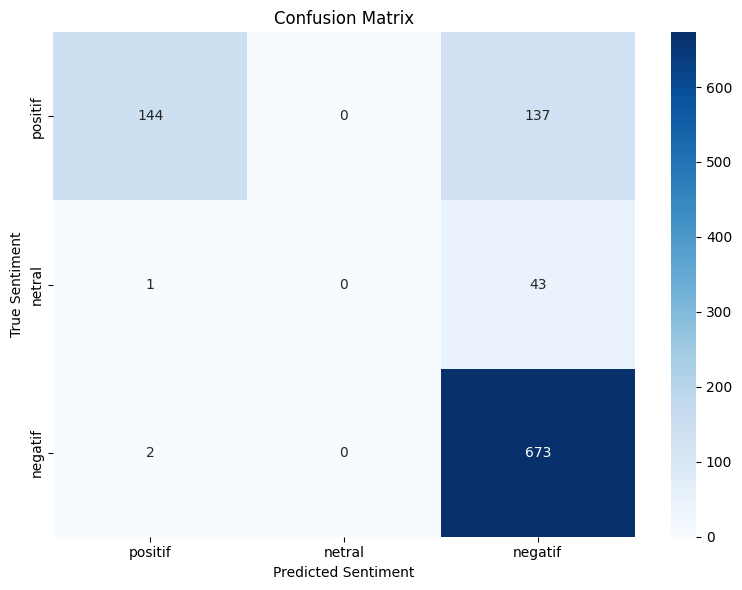

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=['positif', 'netral', 'negatif'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positif', 'netral', 'negatif'], yticklabels=['positif', 'netral', 'negatif'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.tight_layout()
plt.show()

# LDA

Fine-Tuning LDA untuk Menentukan Jumlah Topik yang Optimal

In [22]:
def tune_lda(corpus, dictionary, num_topics_list, passes=10, alpha='auto', eta='auto'):
    coherence_scores = []
    for num_topics in num_topics_list:
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, alpha=alpha, eta=eta)

        coherence_model = CoherenceModel(model=lda_model, texts=[text.split() for text in df_selected['cleaned_review']], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))

        print(f"\nTopik untuk {num_topics} topik:")
        for idx, topic in lda_model.print_topics(-1):
            print(f"Topik {idx}:\n{topic}\n")

    return coherence_scores

texts_for_lda = [text.split() for text in df_selected['cleaned_review']]
dictionary = corpora.Dictionary(texts_for_lda)
corpus = [dictionary.doc2bow(text) for text in texts_for_lda]


num_topics_list = [5,10,15,20]
coherence_scores = tune_lda(corpus, dictionary, num_topics_list)

coherence_df = pd.DataFrame(coherence_scores, columns=['Num Topics', 'Coherence Score'])
print("\nCoherence Scores for each num_topics:")
print(coherence_df)


Topik untuk 5 topik:
Topik 0:
0.048*"aplikasi" + 0.043*"tidak" + 0.031*"kuota" + 0.021*"mau" + 0.015*"buka" + 0.015*"loading" + 0.015*"cek" + 0.014*"beli" + 0.013*"lama" + 0.013*"paket"

Topik 1:
0.077*"makin" + 0.050*"mahal" + 0.037*"paket" + 0.034*"harga" + 0.025*"telkomsel" + 0.024*"jaring" + 0.015*"gb" + 0.015*"kuota" + 0.014*"lama" + 0.013*"lot"

Topik 2:
0.048*"aplikasi" + 0.034*"sinyal" + 0.033*"jaring" + 0.029*"apk" + 0.024*"lot" + 0.022*"sering" + 0.022*"buka" + 0.016*"padahal" + 0.014*"banget" + 0.013*"buat"

Topik 3:
0.025*"tidak" + 0.025*"sinyal" + 0.020*"telkomsel" + 0.020*"jelek" + 0.020*"banget" + 0.017*"jaring" + 0.017*"mahal" + 0.015*"udah" + 0.013*"pulsa" + 0.013*"paket"

Topik 4:
0.061*"sangat" + 0.029*"baik" + 0.029*"bagus" + 0.023*"aplikasi" + 0.022*"pulsa" + 0.019*"paket" + 0.017*"telkomsel" + 0.014*"lebih" + 0.013*"beli" + 0.010*"guna"


Topik untuk 10 topik:
Topik 0:
0.076*"makin" + 0.038*"telkomsel" + 0.033*"parah" + 0.019*"lot" + 0.014*"busuk" + 0.014*"lelet"

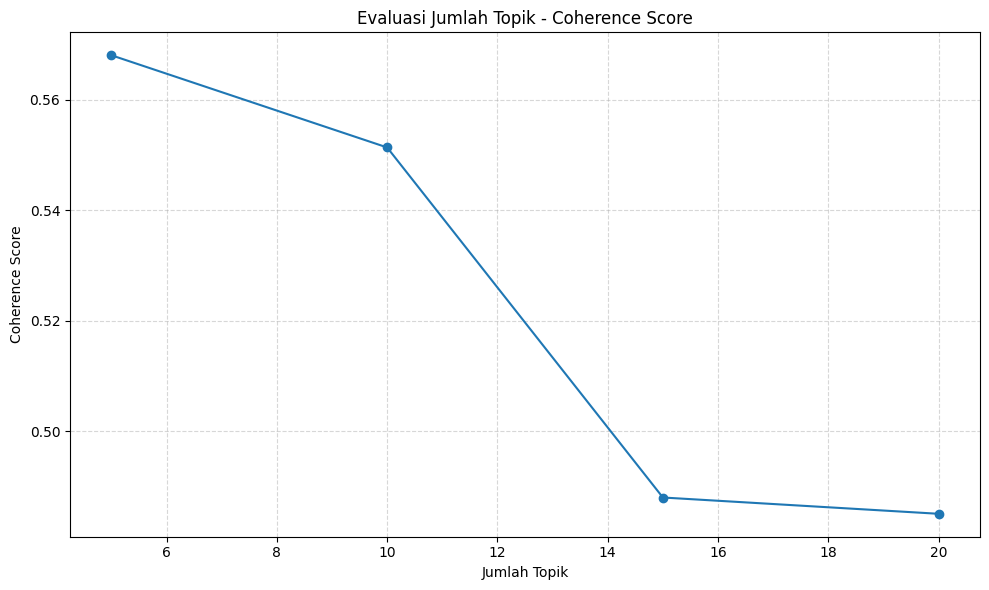

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(coherence_df['Num Topics'], coherence_df['Coherence Score'], marker='o')
plt.xlabel('Jumlah Topik')
plt.ylabel('Coherence Score')
plt.title('Evaluasi Jumlah Topik - Coherence Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Memilih Jumlah Topik dengan Coherence Score Terbaik

In [26]:
best_num_topics = coherence_df.loc[coherence_df['Coherence Score'].idxmax()]['Num Topics']
print(f"\nJumlah topik terbaik berdasarkan Coherence Score: {best_num_topics}")


Jumlah topik terbaik berdasarkan Coherence Score: 5.0


Melatih LDA dengan Jumlah Topik Terbaik

In [27]:
best_lda_model = LdaModel(corpus, num_topics=int(best_num_topics), id2word=dictionary, passes=10, alpha='auto', eta='auto')

print("\nTopik yang Ditemukan oleh LDA (Fine-tuned):")
for idx, topic in best_lda_model.print_topics(-1):
    print(f"Topik {idx}:\n{topic}\n")


Topik yang Ditemukan oleh LDA (Fine-tuned):
Topik 0:
0.028*"paket" + 0.027*"tidak" + 0.026*"pulsa" + 0.020*"telkomsel" + 0.018*"beli" + 0.012*"mantap" + 0.012*"udah" + 0.009*"padahal" + 0.009*"hilang" + 0.009*"tiba"

Topik 1:
0.062*"sangat" + 0.043*"baik" + 0.034*"telkomsel" + 0.023*"bagus" + 0.022*"aplikasi" + 0.015*"banyak" + 0.014*"lebih" + 0.012*"guna" + 0.011*"my" + 0.010*"buat"

Topik 2:
0.064*"aplikasi" + 0.040*"tidak" + 0.029*"jaring" + 0.023*"buka" + 0.017*"sinyal" + 0.016*"susah" + 0.015*"terus" + 0.014*"banget" + 0.014*"apk" + 0.013*"lelet"

Topik 3:
0.053*"aplikasi" + 0.038*"kuota" + 0.028*"tidak" + 0.022*"mau" + 0.022*"lot" + 0.019*"cek" + 0.017*"buka" + 0.016*"loading" + 0.016*"beli" + 0.014*"sering"

Topik 4:
0.066*"makin" + 0.047*"mahal" + 0.032*"paket" + 0.028*"jaring" + 0.028*"harga" + 0.026*"telkomsel" + 0.024*"sinyal" + 0.018*"kuota" + 0.014*"lama" + 0.014*"banget"



Menetapkan Topik Dominan untuk Setiap Ulasan

In [28]:
def get_dominant_topic(corpus, index):
    topic_probabilities = best_lda_model[corpus[index]]
    dominant_topic = max(topic_probabilities, key=lambda item: item[1])[0]
    return dominant_topic

df_selected['dominant_topic'] = [get_dominant_topic(corpus, i) for i in range(len(df_selected))]

print("\n10 Data Pertama dengan Topik Dominan (Fine-tuned):")
print(df_selected[['content', 'sentimen', 'dominant_topic']].head(10))


10 Data Pertama dengan Topik Dominan (Fine-tuned):
                                             content sentimen  dominant_topic
0    Aplikasi yang selalu lemot kalo saat di buka!!!  negatif               3
1  malah gak bisa login.padahal dah di kasih ling...  negatif               2
2  masih sering downd, gabisa nampilin kuota dan ...  negatif               3
3                                                 ok  positif               4
4  1.Jaringan sangat buruk walaupun saya pake kar...  negatif               1
5  ribet lah apk di satuin sama indihome.customer...  negatif               3
6  ada apa dengan My TELKOMSEL kenapa loading mul...  negatif               2
7  sudah sinyal lemot... buka aplikasi lemot.. se...  negatif               3
8  Layanannya sudah lebih lengkap dalam satu apli...  positif               1
9                                                 ok  positif               4


Visualisasi Sentimen per Topik

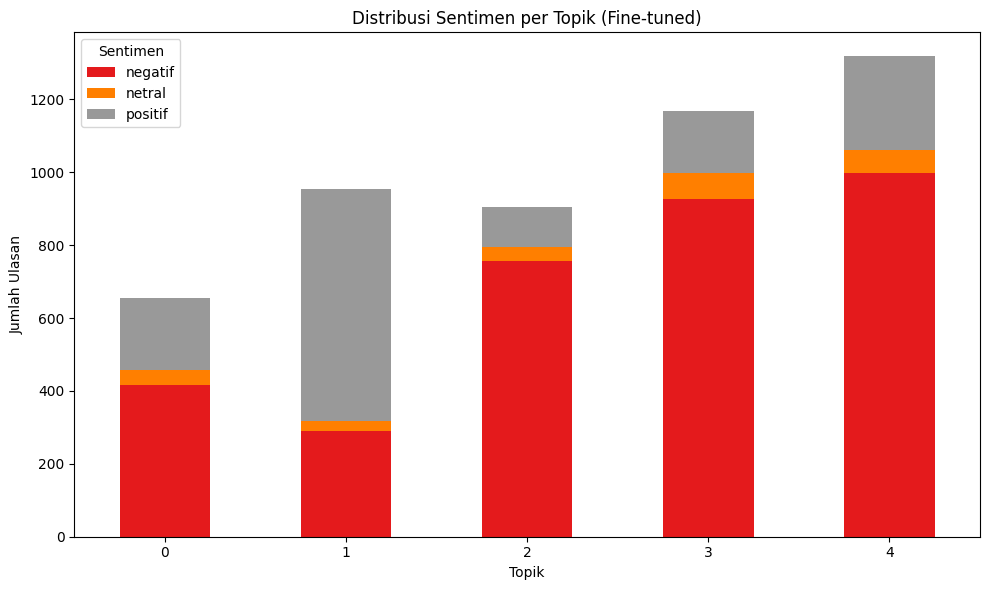

In [29]:
sentiment_by_topic = df_selected.groupby(['dominant_topic', 'sentimen']).size().unstack(fill_value=0)

sentiment_by_topic.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set1')
plt.title('Distribusi Sentimen per Topik (Fine-tuned)')
plt.xlabel('Topik')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=0)
plt.legend(title='Sentimen')
plt.tight_layout()
plt.show()

Menampilkan Contoh Ulasan per Topik

In [30]:
for topic_num in range(int(best_num_topics)):
    print(f"\nContoh Ulasan untuk Topik {topic_num}:\n")
    example_reviews = df_selected[df_selected['dominant_topic'] == topic_num].head(5)
    display(example_reviews[['content', 'sentimen']])


Contoh Ulasan untuk Topik 0:



,content,sentimen
26,hebatnya jaringan Telkomsel paket GK di bikin....,negatif
31,"hampir semua kartu sekarang tolol, pada gak bi...",negatif
32,aplikasi.x mantap,positif
37,urusan sinyal Telkomsel ngak ada matinya.,positif
48,Telkomsel jelek banget sinyal nya udah mahal l...,negatif



Contoh Ulasan untuk Topik 1:



,content,sentimen
4,1.Jaringan sangat buruk walaupun saya pake kar...,negatif
8,Layanannya sudah lebih lengkap dalam satu apli...,positif
18,apk rusak,negatif
33,Bagus,positif
38,bagus,positif



Contoh Ulasan untuk Topik 2:



,content,sentimen
1,malah gak bisa login.padahal dah di kasih ling...,negatif
6,ada apa dengan My TELKOMSEL kenapa loading mul...,negatif
15,jaringan semakin hari semakin lelet. buat chat...,negatif
17,keren,positif
21,Aplikasi nga niat... setiap di buka stuck teru...,negatif



Contoh Ulasan untuk Topik 3:



,content,sentimen
0,Aplikasi yang selalu lemot kalo saat di buka!!!,negatif
2,"masih sering downd, gabisa nampilin kuota dan ...",negatif
5,ribet lah apk di satuin sama indihome.customer...,negatif
7,sudah sinyal lemot... buka aplikasi lemot.. se...,negatif
12,"setiap bulan aplikasi ini, gak ada perubahan k...",negatif



Contoh Ulasan untuk Topik 4:



,content,sentimen
3,ok,positif
9,ok,positif
10,aplikasinya jelek sekali makin lama makin lemo...,negatif
11,"Ini sudah 3 hari lebih data gak bisa dipake,ad...",negatif
14,"may tlkomse ,mantap",positif


Visualisasi Wordcloud per Sentimen

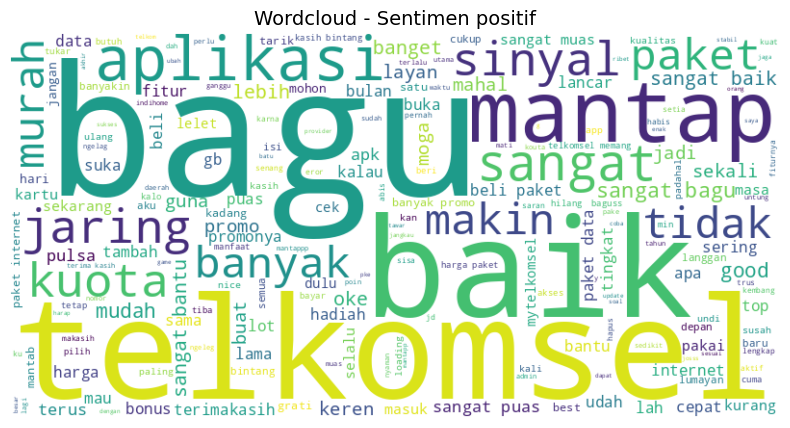

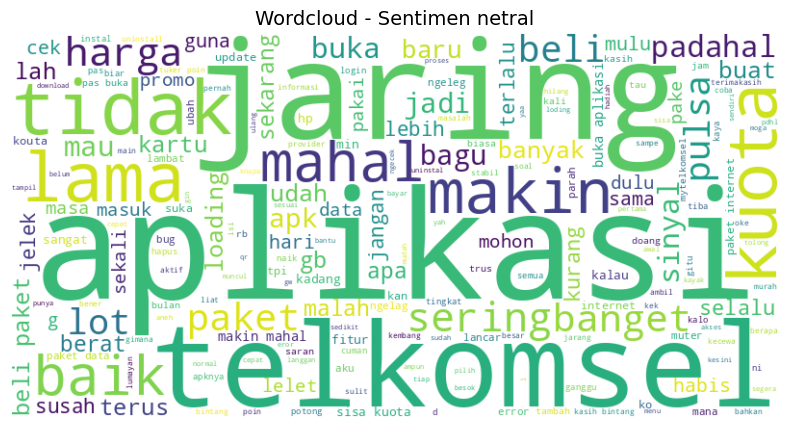

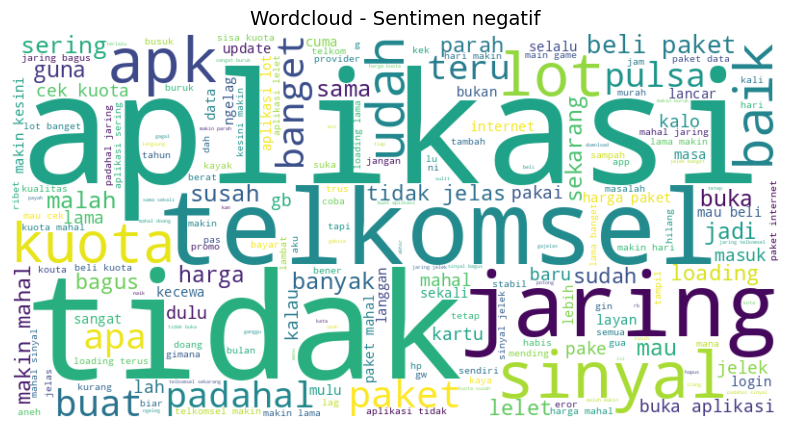

In [31]:
def generate_wordcloud(data, label):
    text = ' '.join(data[data['sentimen'] == label]['cleaned_review'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud - Sentimen {label}', fontsize=14)
    plt.show()

generate_wordcloud(df_selected, 'positif')
generate_wordcloud(df_selected, 'netral')
generate_wordcloud(df_selected, 'negatif')

# Analisis

In [33]:
df_selected.to_csv('hasil_analisis_mytelkomsel.csv', index=False, encoding='utf-8-sig')

# Menampilkan pesan bahwa hasil telah disimpan
print("\nHasil analisis telah disimpan ke 'hasil_analisis_mytelkomsel.csv'.")


Hasil analisis telah disimpan ke 'hasil_analisis_mytelkomsel.csv'.


### Solusi Bisnis, Topik, dan Area untuk Telkomsel

| **Topik**                                 | **Area**                                | **Masalah**                                                                      | **Solusi Bisnis**                                                                                                                                                                                                                                                |
| ----------------------------------------- | --------------------------------------- | -------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Kualitas Jaringan**                     | Jaringan dan Infrastruktur              | Kualitas jaringan buruk dan tidak stabil, terutama di daerah pedesaan dan padat. | 1. **Investasi Ekspansi Infrastruktur** di daerah dengan masalah sinyal.<br> 2. **Pemeliharaan dan Peningkatan Infrastruktur**.<br> 3. Fokus pada pengembangan **5G** dan penguatan **4G LTE**.                                                                  |
| **Performa Aplikasi**                     | Aplikasi Mobile                         | Aplikasi lambat, tidak bisa dibuka, atau gagal loading.                          | 1. **Optimalisasi Aplikasi** untuk meningkatkan waktu pemuatan dan mengurangi crash.<br> 2. **Pengujian pada berbagai perangkat** untuk memastikan kompatibilitas.<br> 3. Fokus pada **fitur utama aplikasi** seperti pengecekan kuota dan pembelian paket.      |
| **Harga Paket**                           | Penetapan Harga dan Paket               | Harga paket semakin mahal tanpa kualitas yang memadai.                           | 1. **Evaluasi dan Penyesuaian Harga** untuk memastikan paket yang lebih terjangkau dan sesuai kebutuhan.<br> 2. Pengembangan **paket fleksibel** yang disesuaikan dengan kebutuhan pelanggan.<br> 3. **Program loyalitas dan penghargaan** bagi pelanggan setia. |
| **Pengelolaan Kuota dan Pembelian Paket** | Pengelolaan Layanan dan Pembelian Paket | Kesulitan dalam pengecekan kuota dan pembelian paket yang bermasalah.            | 1. **Perbaikan di sistem backend** untuk memastikan kuota dan paket ditampilkan dengan cepat dan akurat.<br> 2. **Integrasi platform lain** untuk mempermudah pengecekan kuota.<br> 3. Menambahkan **notifikasi pengingat** saat kuota hampir habis.             |
| **Layanan Pelanggan**                     | Layanan Pelanggan dan Support           | Layanan pelanggan lambat dalam menangani keluhan.                                | 1. **Peningkatan Layanan Pelanggan** dengan menambah **multisaluran** dan **chatbot AI** untuk respons yang lebih cepat.<br> 2. Meningkatkan **waktu respons** pada keluhan pelanggan yang lebih mendesak.                                                       |
| **Pemantauan Umpan Balik Pengguna**       | Analisis Sentimen dan Feedback          | Kurangnya pemantauan rutin terhadap feedback pengguna.                           | 1. **Pemantauan Sentimen Secara Real-time** untuk menangkap keluhan dan umpan balik pengguna lebih cepat.<br> 2. Membuat **sistem feedback loop** untuk perbaikan berkelanjutan.                                                                                 |


### **Insight yang Lebih Mendalam:**

1. **Kualitas Jaringan**:

   * Telkomsel mengalami banyak keluhan terkait **kualitas jaringan** mereka, yang tampaknya tidak memadai untuk memenuhi kebutuhan pelanggan. Hal ini sangat terasa di **daerah pedesaan** dan beberapa **area padat penduduk**, di mana kualitas sinyal seringkali lemah atau bahkan tidak tersedia.

2. **Performa Aplikasi Mobile**:

   * Aplikasi Telkomsel mengalami masalah teknis yang serius, termasuk **waktu loading yang lama** dan **seringnya aplikasi tidak responsif**. Hal ini menyulitkan pengguna dalam mengakses layanan penting seperti **cek kuota** dan **pembelian paket**.

3. **Harga Paket**:

   * Dengan harga paket yang semakin **mahal** namun tidak diimbangi dengan **peningkatan kualitas layanan**, banyak pelanggan merasa bahwa Telkomsel tidak memberikan **nilai yang cukup** dalam layanan mereka, terutama di tengah persaingan yang semakin ketat dengan operator lain.

4. **Pengelolaan Kuota dan Pembelian Paket**:

   * Masalah dengan **pembelian paket** dan **pengecekan kuota** yang sering mengalami gangguan sangat mengganggu pengalaman pengguna. Hal ini menyebabkan ketidaknyamanan, terutama ketika pengguna ingin mengecek sisa kuota atau membeli paket secara mendesak.

5. **Layanan Pelanggan**:

   * Banyak pengguna yang mengeluhkan **respon lambat** dari layanan pelanggan Telkomsel, terutama dalam menyelesaikan masalah terkait **jaringan** dan **performa aplikasi**. Ini menunjukkan bahwa sistem layanan pelanggan yang ada saat ini kurang efisien dan belum dapat memberikan solusi yang memadai bagi pengguna.

6. **Pemantauan Umpan Balik Pengguna**:

   * Telkomsel tampaknya kurang memanfaatkan teknologi pemantauan sentimen yang dapat menangkap **keluhan pelanggan** secara **real-time**. Ini menghambat kemampuan perusahaan untuk segera merespons masalah dan memperbaiki kualitas layanan mereka.

---

### **Kesimpulan:**

1. **Fokus pada Peningkatan Infrastruktur Jaringan**: Telkomsel harus segera memperkuat **infrastruktur jaringan** mereka dengan memperluas **menara seluler**, melakukan **pemeliharaan** lebih sering, dan memperkenalkan teknologi **5G** untuk memenuhi tuntutan pasar.

2. **Perbaikan Aplikasi Mobile**: Optimalisasi **aplikasi mobile** Telkomsel sangat penting agar pelanggan dapat mengakses layanan dengan lebih cepat dan tanpa gangguan. Aplikasi yang responsif dan stabil akan sangat meningkatkan **pengalaman pengguna**.

3. **Penyesuaian Harga yang Adil dan Transparan**: Telkomsel perlu melakukan **evaluasi ulang** terhadap **harga paket** mereka, memastikan bahwa harga yang ditawarkan sesuai dengan kualitas layanan yang diberikan. Penyediaan paket dengan harga lebih kompetitif dan **program loyalitas** dapat membantu mempertahankan pelanggan.

4. **Perbaikan Sistem Pembelian Paket dan Pengecekan Kuota**: Telkomsel harus meningkatkan **backend sistem** mereka untuk memastikan pengguna dapat mengecek kuota dan membeli paket dengan cepat tanpa adanya gangguan teknis.

5. **Peningkatan Layanan Pelanggan**: Telkomsel perlu mengurangi waktu respons dengan meningkatkan **sistem layanan pelanggan** mereka, serta menerapkan **chatbot AI** untuk memberikan respons yang lebih cepat dan efisien.

6. **Pemantauan Sentimen dan Feedback yang Rutin**: Telkomsel harus memanfaatkan **teknologi pemantauan sentimen** untuk mendapatkan wawasan tentang pengalaman pelanggan secara **real-time** dan merespons masalah dengan lebih cepat dan tepat.

Dengan menerapkan solusi-solusi ini, Telkomsel dapat memperbaiki kualitas layanan mereka, meningkatkan **kepuasan pelanggan**, dan menjaga loyalitas pengguna dalam jangka panjang.
